In [1]:
# imports
import numpy as np

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from itertools import groupby

from dataset import parse_manifest

In [2]:
# constants
data_path = 'datasets/VCTK/hubert100'
device = 'cuda:0'

In [3]:
def dedup_seq(seq):
    vals, counts = zip(*[(k, sum(1 for i in g)) for k,g in groupby(seq)])
    return vals, counts

In [115]:
def prepare_dataset(path, spk_id_dict):
    names, seqs = parse_manifest(path)
    speakers = [n.name.split('_')[0] for n in names]
    
    all_vals, all_counts, spk_ids = [], [], []
    for name, seq in zip(speakers, seqs):
        vals, counts = dedup_seq(seq)
        all_vals.append(torch.IntTensor(vals))
        all_counts.append(torch.FloatTensor(counts))
        spk_ids.append(torch.IntTensor([spk_id_dict[name]]))
    return pad_sequence(all_vals, batch_first=True, padding_value=100), pad_sequence(all_counts, batch_first=True, padding_value=-1), torch.concat(spk_ids).view(-1, 1)

In [105]:
def get_spkrs_dict(path):
    names, _ = parse_manifest(path)
    speakers = [n.name.split('_')[0] for n in names]
    spk_id_dict = {n:i for i, n in enumerate(np.unique(speakers))}
    return spk_id_dict

In [108]:
class LenDataset(Dataset):
    def __init__(self, path, spk_id_dict):
        self.vals, self.lens, self.spk_ids = prepare_dataset(path, spk_id_dict)
        
    def __len__(self):
        return len(self.vals)
    
    def __getitem__(self, i):
        return self.vals[i], self.lens[i], self.spk_ids[i]

In [176]:
class LenPredictor(nn.Module):
    def __init__(self, token_dict_size=100, spk_dict_size=199, emb_size=32):
        super(LenPredictor, self).__init__()
        
        self.token_emb = nn.Embedding(token_dict_size + 1, emb_size, padding_idx=token_dict_size)
        self.spk_emb = nn.Embedding(spk_dict_size + 1, emb_size, padding_idx=spk_dict_size)
        self.leaky = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.cnn1 = nn.Conv1d(2*emb_size, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.cnn11 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm1d(128)
        self.cnn12 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm1d(128)
        
        self.cnn2 = nn.Conv1d(128, 1, kernel_size=3, padding=1)
        
    def forward(self, seq, spk_id):
        emb_seq = self.token_emb(seq)
        emb_spk = torch.repeat_interleave(self.spk_emb(spk_id), seq.shape[-1], dim=1)
        emb_seq = torch.cat([emb_seq, emb_spk], dim=-1)
        
        cnn1 = self.leaky(self.dropout(self.bn1(self.cnn1(emb_seq.transpose(1, 2)))))
        cnn1 = self.leaky(self.dropout(self.bn11(self.cnn11(cnn1))))
        cnn1 = self.leaky(self.dropout(self.bn12(self.cnn12(cnn1))))
        return self.cnn2(cnn1).squeeze(1)

In [177]:
class LenLoss(nn.Module):
    def __init__(self, pad_idx=-1):
        super(LenLoss, self).__init__()
        self.pad_idx = pad_idx
        self.mse = nn.MSELoss(reduction='none')
    
    def forward(self, preds, lens):
        mask = (lens != self.pad_idx)
        total_loss = self.mse(preds, lens)        
        return (mask * total_loss).sum() / mask.sum()

In [178]:
spk_id_dict = get_spkrs_dict(f'{data_path}/train.txt')  # at the moment this doesn't support unseen speakers

In [180]:
ds_train = LenDataset(f'{data_path}/train.txt', spk_id_dict)
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)

ds_val = LenDataset(f'{data_path}/val.txt', spk_id_dict)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False)

In [181]:
model = LenPredictor()
model.to(device)

LenPredictor(
  (token_emb): Embedding(101, 32, padding_idx=100)
  (spk_emb): Embedding(200, 32, padding_idx=199)
  (leaky): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (cnn1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn11): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn12): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn2): Conv1d(128, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [182]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
len_loss = LenLoss()

In [183]:
for epoch in range(100):
    print(f'\nEpoch: {epoch}')
    
    model.train()
    total_train_loss = 0
    for i, batch in enumerate(dl_train):
        seqs, lens, spk_id = batch
        seqs = seqs.to(device)
        lens = lens.to(device)
        spk_id = spk_id.to(device)
        opt.zero_grad()

        preds = model(seqs, spk_id)
        loss = len_loss(preds, lens)
        loss.backward()
        opt.step()
        total_train_loss += loss

        print(f'\r finished: {100*i/len(dl_train):.2f}%, train loss: {loss:.5f}', end='')
    
    # validation 
    model.eval()
    total_val_loss = 0
    for i, batch in enumerate(dl_val):
        seqs, lens, spk_id = batch
        seqs = seqs.to(device)
        lens = lens.to(device)
        spk_id = spk_id.to(device)
        with torch.no_grad():
            preds = model(seqs, spk_id)
            loss = len_loss(preds, lens)
        total_val_loss += loss
    
    print(f'\ntotal_train_loss: {total_train_loss/len(dl_train):.5f}')
    print(f'total_val_loss: {total_val_loss/len(dl_val):.5f}')


Epoch: 0
 finished: 99.92%, train loss: 2.288812
total_train_loss: 2.88947
total_val_loss: 2.28749

Epoch: 1
 finished: 99.92%, train loss: 1.534668
total_train_loss: 2.46791
total_val_loss: 2.07699

Epoch: 2
 finished: 99.92%, train loss: 1.338702
total_train_loss: 2.35756
total_val_loss: 1.96483

Epoch: 3
 finished: 99.92%, train loss: 1.970320
total_train_loss: 2.29910
total_val_loss: 1.89826

Epoch: 4
 finished: 99.92%, train loss: 1.730512
total_train_loss: 2.25899
total_val_loss: 1.88942

Epoch: 5
 finished: 99.92%, train loss: 1.772251
total_train_loss: 2.22439
total_val_loss: 1.83305

Epoch: 6
 finished: 99.92%, train loss: 1.285112
total_train_loss: 2.20388
total_val_loss: 1.82074

Epoch: 7
 finished: 99.92%, train loss: 1.491398
total_train_loss: 2.18589
total_val_loss: 1.81707

Epoch: 8
 finished: 99.92%, train loss: 1.370283
total_train_loss: 2.17813
total_val_loss: 1.80242

Epoch: 9
 finished: 99.92%, train loss: 1.875250
total_train_loss: 2.15425
total_val_loss: 1.79382


KeyboardInterrupt: 

In [184]:
total_preds, total_lens = [], []
# infer 
model.eval()
for i, batch in enumerate(dl_val):
    seqs, lens, spk_id = batch
    seqs = seqs.to(device)
    lens = lens.to(device)
    spk_id = spk_id.to(device)
    with torch.no_grad():
        preds = model(seqs, spk_id)
    total_preds.append(preds)
    total_lens.append(lens)

In [185]:
total_preds = torch.cat(total_preds)
total_lens = torch.cat(total_lens)

In [236]:
rel_diff = (torch.round(torch.clip(total_preds, 1)) - total_lens).abs()[total_lens != 100]
# rel_diff = (torch.round(total_preds) - total_lens).abs()[total_lens != 100]
(rel_diff >= 35).sum()

tensor(11, device='cuda:0')

(array([9.7446e+04, 6.4358e+04, 9.5530e+03, 3.0730e+03, 1.3600e+03,
        0.0000e+00, 7.1500e+02, 4.5200e+02, 2.5400e+02, 1.8200e+02,
        1.2500e+02, 0.0000e+00, 7.7000e+01, 6.0000e+01, 4.9000e+01,
        3.6000e+01, 2.1000e+01, 0.0000e+00, 1.4000e+01, 1.1000e+01,
        1.2000e+01, 9.0000e+00, 7.0000e+00, 0.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

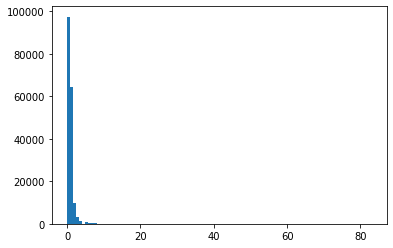

In [229]:
plt.hist(rel_diff.cpu().numpy(), bins=100)

In [219]:
a = rel_diff.cpu().numpy()
a[np.argpartition(a, -20)[-20:]]

array([25., 25., 29., 35., 42., 37., 25., 32., 43., 74., 64., 29., 36.,
       28., 39., 74., 29., 40., 28., 83.], dtype=float32)

In [209]:
# import matplotlib.pyplot as plt
np.unique(total_lens[total_lens != 100].cpu().numpy(), return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 37., 41., 42., 43., 46.,
        47., 49., 79., 81., 82., 87.], dtype=float32),
 array([89056, 50864, 17957,  9052,  4681,  2055,  1187,   785,   544,
          362,   251,   218,   161,   134,   100,    84,    59,    56,
           46,    41,    28,    32,    16,    15,    12,     9,     4,
            6,     5,     1,     6,     2,     3,     1,     1,     1,
            1,     1,     2,     1,     1,     1,     1,     1,     1]))

In [214]:
a = total_preds[total_lens != 100].cpu().numpy()
a[np.argpartition(a, -10)[-10:]]

array([22.052786, 22.219421, 22.324633, 22.708384, 22.726074, 22.951706,
       27.996572, 31.15078 , 26.92656 , 24.947197], dtype=float32)

In [193]:
(total_lens[total_lens != 100] == 1).sum()/ len(rel_diff)

tensor(0.5008, device='cuda:0')

In [215]:
np.unique(ds_train.lens.numpy(), return_counts=True)

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
         56.,  57.,  58.,  59.,  60.,  62.,  63.,  64.,  65.,  66.,  67.,
         68.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
         80.,  82.,  84.,  85.,  87.,  88.,  89.,  90.,  91.,  92.,  94.,
         95.,  98., 100., 101., 103., 105., 106., 107., 108., 111., 116.,
        119., 120., 122., 123., 125., 133., 139., 142., 146., 149., 154.,
        159., 166., 184., 242., 243., 365.], dtype=float32),
 array([ 1630662,   934798,   332029,   163104,    86254,    37399,
           22184,    14335,     9788,     6918,     5161,     3964,
            2987,     2375,     1833,     1540,     1285,     1

In [160]:
total_lens.shape

torch.Size([2174, 312])